In [5]:
import pandas as pd  # Importing pandas for data manipulation and analysis
import seaborn as sns  # Importing seaborn for advanced data visualization
import matplotlib.pyplot as plt  # Importing matplotlib for plotting graphs and charts


In [3]:
train_url = "https://huggingface.co/datasets/zeroshot/twitter-financial-news-sentiment/resolve/main/sent_train.csv"
test_url = "https://huggingface.co/datasets/zeroshot/twitter-financial-news-sentiment/resolve/main/sent_valid.csv"

# Load CSVs into DataFrames from the URLs
df_train = pd.read_csv(train_url)  # Load training data
df_test = pd.read_csv(test_url)    # Load validation/test data

# Combine into one dataset
df = pd.concat([df_train, df_test], ignore_index=True)  # Merge both datasets into a single DataFrame

# Map sentiment labels to text
label_map = {0: "Bearish", 1: "Bullish", 2: "Neutral"}  # Define mapping from numerical to textual sentiment labels
df['sentiment'] = df['label'].map(label_map)  # Apply mapping to create a new 'sentiment' column

# Display basic info
print("Total samples:", df.shape)  # Print total number of samples
df.head()  # Display the first few rows of the combined dataset


Total samples: (11931, 3)


,text,label,sentiment
0,$BYND - JPMorgan reels in expectations on Beyo...,0,Bearish
1,$CCL $RCL - Nomura points to bookings weakness...,0,Bearish
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0,Bearish
3,$ESS: BTIG Research cuts to Neutral https://t....,0,Bearish
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0,Bearish


In [4]:
import re

def clean_text(text):
    text = re.sub(r"http\S+|www.\S+", "", text)  # Remove URLs starting with http or www
    text = re.sub(r"@\w+|\$\w+", "", text)       # Remove Twitter mentions (@user) and stock tickers ($TSLA)
    text = re.sub(r"[^A-Za-z\s]", "", text)      # Remove non-alphabetic characters and punctuation
    text = text.lower().strip()                  # Convert text to lowercase and remove leading/trailing whitespace
    return text

df['clean_text'] = df['text'].apply(clean_text)  # Apply text cleaning function to original tweets
df[['text', 'clean_text', 'sentiment']].sample(5)  # Display a random sample of 5 rows showing original, cleaned, and sentiment


,text,clean_text,sentiment
8123,Why Fiverr Stock Rose 11% in January,why fiverr stock rose in january,Bullish
1835,RevoluGROUP Canada Inc. Correction RedCHAPINA ...,revolugroup canada inc correction redchapina d...,Neutral
1880,SocGen Pledges Higher Returns After Dropping P...,socgen pledges higher returns after dropping p...,Neutral
4813,London Stock Exchange : PMPs in Hawaii can now...,london stock exchange pmps in hawaii can now ...,Neutral
832,Lowe's says it will shut 34 stores in Canada,lowes says it will shut stores in canada,Bearish


In [5]:

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)  # Initialize TF-IDF vectorizer with a limit of 5000 most informative features
X = vectorizer.fit_transform(df['clean_text'])   # Fit the vectorizer on cleaned text and transform it into a sparse matrix
y = df['sentiment']                              # Extract sentiment labels as target variable



In [8]:

import nltk
nltk.download('punkt')         # Download the Punkt tokenizer model for sentence splitting and tokenization
nltk.download('punkt_tab')     # Attempt to download 'punkt_tab'



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [9]:
# Word2Vec Embedding using Gensim (CBOW)

from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

# Tokenize the cleaned text
tokenized_text = df['clean_text'].apply(word_tokenize)

# Train Word2Vec model (CBOW by default; use sg=1 for Skip-gram)
w2v_model = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=2, workers=4, sg=0)  # sg=0 for CBOW, sg=1 for Skip-gram

# Example: get vector for word "market"
print(w2v_model.wv['market'])

# Average word embeddings for each document
import numpy as np

def document_vector(doc):
    doc = [word for word in doc if word in w2v_model.wv]
    return np.mean(w2v_model.wv[doc], axis=0) if doc else np.zeros(w2v_model.vector_size)

X_embed = np.array([document_vector(doc) for doc in tokenized_text])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[-0.7822055   0.45768306  1.042872    0.2310623  -0.5302471  -0.49883857
  0.4098418   0.5585703  -0.49518135 -0.8201029   0.21225336 -1.0632545
  0.35691562  0.2038563   0.22636244 -0.2891787  -0.15825187 -0.8255859
  0.1422348  -0.3703276  -0.1128554   0.24029367  0.25361916 -0.4046428
 -0.00176773  0.19170535 -0.567198    0.3923381  -0.15081044  0.32514244
 -0.06556735  0.19697131  0.12907952 -0.05998231  0.0403206   0.43813103
  0.4314151  -1.1487119   0.06265513 -0.93935806 -0.16025664 -0.6054989
  0.05573886  0.7893389   0.31176385 -0.5081864  -1.1857021   0.00355441
 -0.21639505  0.19885552 -0.01180099 -0.25349343 -0.24366067 -0.44946882
  0.24860597  0.30748302  0.10494596  0.45501366 -0.1955016   0.10007709
 -0.12975678 -0.26586154 -0.00176136 -0.28527424 -0.66486365  0.02581805
 -0.53889143  0.4704384  -0.2502668   0.7214542  -0.3443033   1.0952804
  0.54467934 -0.10047223  0.9720284   1.0719336   0.4378908  -0.32488385
 -0.2665975   0.49454477 -0.07403287  0.0032022  -0.1458

In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()                  # Initialize label encoder to convert sentiment labels into numeric form
y_encoded = le.fit_transform(y)     # Fit the encoder and transform sentiment labels (e.g., Bearish → 0, Bullish → 1, etc.)


In [11]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
# stratify=y_encoded ensures the class distribution is preserved in both splits
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Define parameter grid for Logistic Regression
# 'C' controls regularization strength; 'penalty' and 'solver' are fixed here
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['liblinear']
}

# Run GridSearchCV to perform hyperparameter tuning with 5-fold cross-validation
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)  # Fit the model using the training data

# Output the best parameters and cross-validation score
print("Best Parameters:", grid.best_params_)
print("Best Cross-Validation Accuracy:", grid.best_score_)

# Evaluate the best model on the test set
y_pred_grid = grid.predict(X_test)
print("Test Accuracy (Tuned Logistic Regression):", accuracy_score(y_test, y_pred_grid))
print("\nClassification Report:\n", classification_report(y_test, y_pred_grid, target_names=le.classes_))


Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Best Cross-Validation Accuracy: 0.8054275620392426
Test Accuracy (Tuned Logistic Regression): 0.8232090490155006

Classification Report:
               precision    recall  f1-score   support

     Bearish       0.76      0.57      0.65       358
     Bullish       0.79      0.63      0.70       480
     Neutral       0.84      0.94      0.89      1549

    accuracy                           0.82      2387
   macro avg       0.80      0.72      0.75      2387
weighted avg       0.82      0.82      0.82      2387



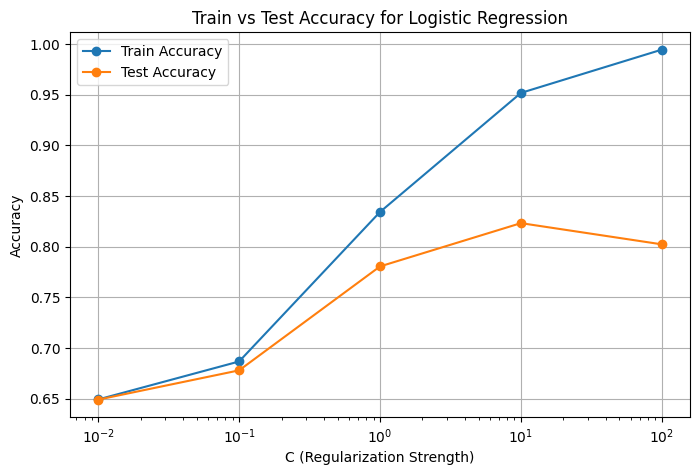

In [15]:
import matplotlib.pyplot as plt

# Define a list of regularization strengths to evaluate
C_values = [0.01, 0.1, 1, 10, 100]
train_accuracies = []  # List to store training accuracy for each C
test_accuracies = []   # List to store test accuracy for each C

# Loop over each C value, train Logistic Regression, and store accuracies
for c in C_values:
    model = LogisticRegression(C=c, max_iter=1000, solver='liblinear')  # Create model with current C
    model.fit(X_train, y_train)  # Train model
    train_accuracies.append(model.score(X_train, y_train))  # Training accuracy
    test_accuracies.append(model.score(X_test, y_test))     # Test accuracy

# Plot training and test accuracy versus C values
plt.figure(figsize=(8, 5))
plt.plot(C_values, train_accuracies, label='Train Accuracy', marker='o')  # Training accuracy curve
plt.plot(C_values, test_accuracies, label='Test Accuracy', marker='o')    # Test accuracy curve
plt.xscale('log')  # Log scale for C axis to better visualize spread
plt.xlabel('C (Regularization Strength)')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy for Logistic Regression')
plt.legend()
plt.grid(True)
plt.show()


In [16]:
from sklearn.naive_bayes import MultinomialNB

# Train the model using Multinomial Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)  # Fit model to training data

# Predict on test set
y_pred_nb = nb_model.predict(X_test)  # Generate predictions on test data

# Evaluate the model
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))  # Print accuracy score
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb, target_names=le.classes_))  # Detailed metrics


Naive Bayes Accuracy: 0.7670716380393799

Classification Report:
               precision    recall  f1-score   support

     Bearish       0.92      0.30      0.45       358
     Bullish       0.77      0.44      0.56       480
     Neutral       0.76      0.98      0.85      1549

    accuracy                           0.77      2387
   macro avg       0.82      0.57      0.62      2387
weighted avg       0.78      0.77      0.73      2387



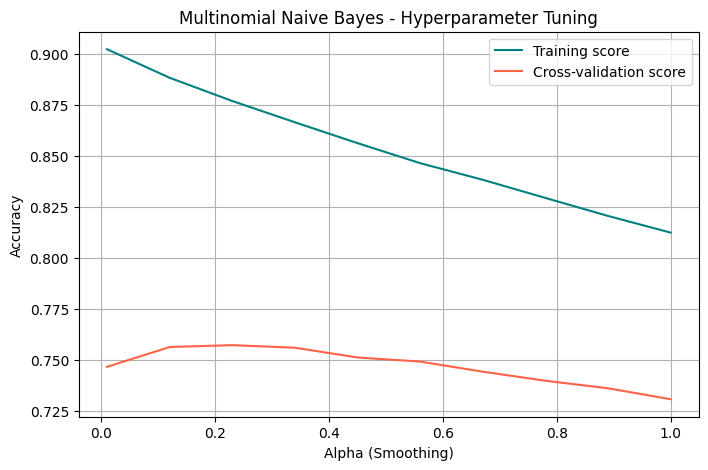

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import validation_curve

# Adjust your data as needed: X = features, y_encoded = encoded labels

param_range = np.linspace(0.01, 1.0, 10)  # Define a range of alpha values for smoothing
train_scores, test_scores = validation_curve(
    MultinomialNB(),
    X, y_encoded,  # Full feature matrix and target labels
    param_name="alpha",  # Hyperparameter to tune
    param_range=param_range,  # Range of values for alpha
    cv=5,  # 5-fold cross-validation
    scoring="accuracy",  # Use accuracy as the scoring metric
    n_jobs=-1  # Utilize all available CPU cores for parallel processing
)

train_mean = train_scores.mean(axis=1)  # Average training scores across folds
test_mean = test_scores.mean(axis=1)  # Average test scores across folds

plt.figure(figsize=(8, 5))
plt.plot(param_range, train_mean, label="Training score", color="teal")  # Plot training accuracy
plt.plot(param_range, test_mean, label="Cross-validation score", color="tomato")  # Plot cross-validation accuracy
plt.xlabel("Alpha (Smoothing)")  # Label for x-axis
plt.ylabel("Accuracy")  # Label for y-axis
plt.title("Multinomial Naive Bayes - Hyperparameter Tuning")  # Plot title
plt.legend(loc="best")  # Show legend
plt.grid(True)  # Show grid for better readability
plt.show()  # Display the plot


In [20]:
from sklearn.ensemble import RandomForestClassifier

# Train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf, target_names=le.classes_))

Random Forest Accuracy: 0.7855048177628823

Classification Report:
               precision    recall  f1-score   support

     Bearish       0.81      0.39      0.52       358
     Bullish       0.74      0.53      0.62       480
     Neutral       0.79      0.96      0.87      1549

    accuracy                           0.79      2387
   macro avg       0.78      0.62      0.67      2387
weighted avg       0.78      0.79      0.77      2387



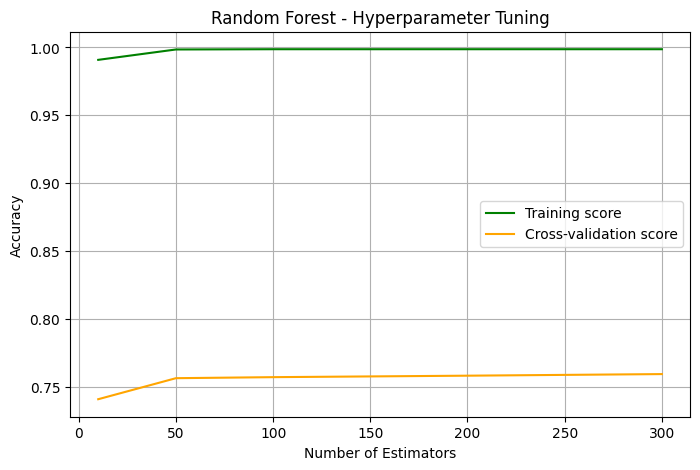

In [21]:
param_range = [10, 50, 100, 200, 300]  # Range of values for number of trees in the forest
train_scores, test_scores = validation_curve(
    RandomForestClassifier(random_state=42),  # Initialize Random Forest with fixed seed
    X, y_encoded,  # Feature matrix and encoded target labels
    param_name="n_estimators",  # Hyperparameter to tune: number of trees
    param_range=param_range,  # List of estimator counts to evaluate
    cv=5,  # Perform 5-fold cross-validation
    scoring="accuracy",  # Use accuracy as the evaluation metric
    n_jobs=-1  # Utilize all CPU cores for parallel processing
)

train_mean = train_scores.mean(axis=1)  # Compute mean training scores across folds
test_mean = test_scores.mean(axis=1)  # Compute mean validation scores across folds

plt.figure(figsize=(8, 5))  # Set figure size
plt.plot(param_range, train_mean, label="Training score", color="green")  # Plot training accuracy
plt.plot(param_range, test_mean, label="Cross-validation score", color="orange")  # Plot validation accuracy
plt.xlabel("Number of Estimators")  # Label for x-axis
plt.ylabel("Accuracy")  # Label for y-axis
plt.title("Random Forest - Hyperparameter Tuning")  # Title of the plot
plt.legend(loc="best")  # Display legend in optimal location
plt.grid(True)  # Enable grid for readability
plt.show()  # Display the plot


In [22]:
from sklearn.svm import LinearSVC

# Train the model
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)

# Predict on test set
y_pred_svm = svm_model.predict(X_test)

# Evaluate the model
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm, target_names=le.classes_))

SVM Accuracy: 0.8240469208211144

Classification Report:
               precision    recall  f1-score   support

     Bearish       0.74      0.59      0.66       358
     Bullish       0.78      0.65      0.71       480
     Neutral       0.85      0.93      0.89      1549

    accuracy                           0.82      2387
   macro avg       0.79      0.72      0.75      2387
weighted avg       0.82      0.82      0.82      2387



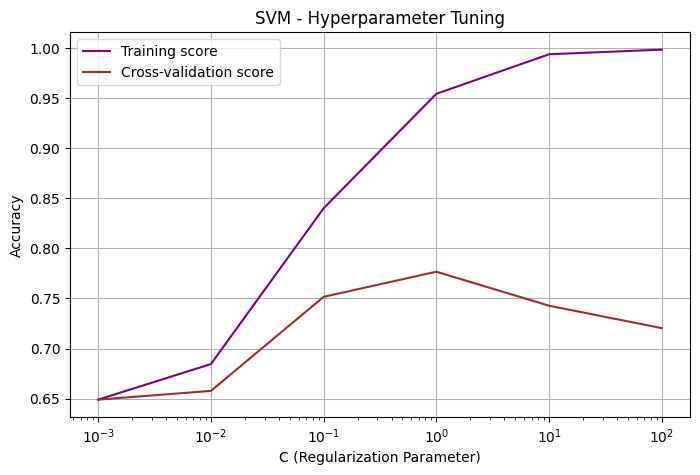

In [23]:
param_range = np.logspace(-3, 2, 6)  # Generate 6 values from 10^-3 to 10^2 for the regularization parameter C
train_scores, test_scores = validation_curve(
    LinearSVC(),  # Use a linear Support Vector Classifier
    X, y_encoded,  # Feature matrix and encoded labels
    param_name="C",  # Hyperparameter to tune: regularization strength
    param_range=param_range,  # Range of C values to test
    cv=5,  # 5-fold cross-validation
    scoring="accuracy",  # Use accuracy as the evaluation metric
    n_jobs=-1  # Use all available processors for parallelization
)

train_mean = train_scores.mean(axis=1)  # Average training scores across folds
test_mean = test_scores.mean(axis=1)  # Average validation scores across folds

plt.figure(figsize=(8, 5))  # Set plot size
plt.plot(param_range, train_mean, label="Training score", color="purple")  # Plot training accuracy
plt.plot(param_range, test_mean, label="Cross-validation score", color="brown")  # Plot validation accuracy
plt.xscale("log")  # Use logarithmic scale for C values
plt.xlabel("C (Regularization Parameter)")  # Label x-axis
plt.ylabel("Accuracy")  # Label y-axis
plt.title("SVM - Hyperparameter Tuning")  # Plot title
plt.legend(loc="best")  # Automatically place legend in best location
plt.grid(True)  # Show gridlines for better readability
plt.show()  # Display the plot


In [24]:
from xgboost import XGBClassifier

# Initialize the XGBoost classifier with specific settings:
# - use_label_encoder=False: disables the use of the internal label encoder
# - eval_metric='mlogloss': sets the evaluation metric to multi-class log loss
# - random_state=42: ensures reproducibility
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Train the XGBoost model on the training data
xgb_model.fit(X_train, y_train)

# Predict labels for the test data
y_pred_xgb = xgb_model.predict(X_test)

# Print the test accuracy of the model
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))

# Print a detailed classification report including precision, recall, and F1-score
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb, target_names=le.classes_))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:35:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.7917888563049853

Classification Report:
               precision    recall  f1-score   support

     Bearish       0.79      0.43      0.56       358
     Bullish       0.79      0.51      0.62       480
     Neutral       0.79      0.96      0.87      1549

    accuracy                           0.79      2387
   macro avg       0.79      0.64      0.68      2387
weighted avg       0.79      0.79      0.77      2387



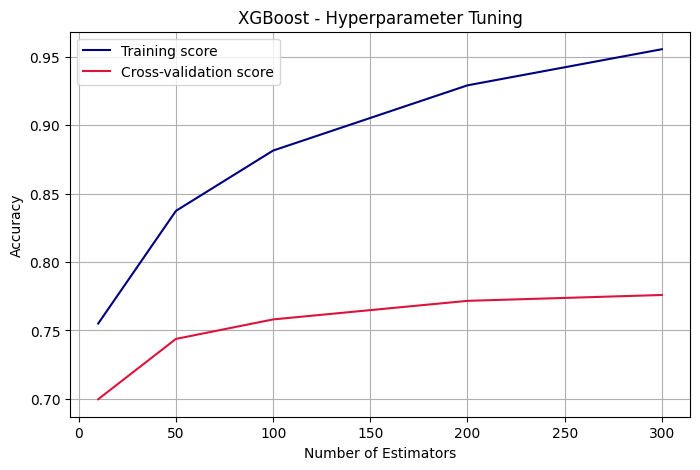

In [25]:
param_range = [10, 50, 100, 200, 300]

# Perform validation curve analysis for XGBoost with varying n_estimators
train_scores, test_scores = validation_curve(
    XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),  # XGBoost model
    X, y_encoded,                          # Features and encoded labels
    param_name="n_estimators",             # Hyperparameter to tune
    param_range=param_range,               # Range of values to try for n_estimators
    cv=5,                                  # 5-fold cross-validation
    scoring="accuracy",                    # Use accuracy as the evaluation metric
    n_jobs=-1                              # Use all available cores for parallel processing
)

# Compute mean training and test scores across folds
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

# Plot the validation curve
plt.figure(figsize=(8, 5))
plt.plot(param_range, train_mean, label="Training score", color="navy")        # Training scores
plt.plot(param_range, test_mean, label="Cross-validation score", color="crimson")  # Validation scores
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy")
plt.title("XGBoost - Hyperparameter Tuning")
plt.legend(loc="best")
plt.grid(True)
plt.show()


In [22]:
import re

# Basic text cleaning function
def clean_text(text):
    text = text.lower()                          # lowercase
    text = re.sub(r'http\S+', '', text)          # remove URLs
    text = re.sub(r'@\w+', '', text)             # remove mentions
    text = re.sub(r'#\w+', '', text)             # remove hashtags
    text = re.sub(r'[^a-z\s]', '', text)         # remove punctuation/numbers
    text = re.sub(r'\s+', ' ', text).strip()     # remove extra spaces
    return text

# Apply to 'text' column from the dataset
df['clean_text'] = df['text'].astype(str).apply(clean_text)


In [11]:
#  Install and import dependencies
!pip install tensorflow

In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#  Preprocess and encode

vocab_size = 10000                # Maximum number of words to keep in tokenizer vocabulary
max_length = 100                  # Maximum sequence length for padding
oov_token = "<OOV>"               # Token to represent out-of-vocabulary words

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)     # Initialize tokenizer
tokenizer.fit_on_texts(df['clean_text'])                             # Learn word index from text
sequences = tokenizer.texts_to_sequences(df['clean_text'])           # Convert text to sequences of integers
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')  # Pad sequences

label_encoder = LabelEncoder()                                       # Initialize label encoder
y_encoded = label_encoder.fit_transform(df['sentiment'])             # Encode sentiment labels

#  Train/Test split

X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(
    padded_sequences, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42  # Stratify ensures label balance
)

#  LSTM Model

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length),  # Word embedding layer
    LSTM(64),                                                                   # LSTM layer with 64 units
    Dropout(0.5),                                                               # Dropout for regularization
    Dense(3, activation='softmax')                                              # Output layer with 3 classes
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])  # Compile model
history = model.fit(X_train_lstm, y_train_lstm, epochs=5, batch_size=32, validation_split=0.1)  # Train with 10% val split

#  Evaluation

loss, accuracy = model.evaluate(X_test_lstm, y_test_lstm)     # Evaluate on test set
print(f"LSTM Accuracy: {accuracy:.4f}")                        # Print final test accuracy


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


269/269 ━━━━━━━━━━━━━━━━━━━━ 47s 154ms/step - accuracy: 0.6296 - loss: 0.9260 - val_accuracy: 0.6471 - val_loss: 0.8957
Epoch 2/5
269/269 ━━━━━━━━━━━━━━━━━━━━ 60s 74ms/step - accuracy: 0.6552 - loss: 0.8852 - val_accuracy: 0.6471 - val_loss: 0.8926
Epoch 3/5
269/269 ━━━━━━━━━━━━━━━━━━━━ 32s 118ms/step - accuracy: 0.6455 - loss: 0.8952 - val_accuracy: 0.6471 - val_loss: 0.8981
Epoch 4/5
269/269 ━━━━━━━━━━━━━━━━━━━━ 30s 77ms/step - accuracy: 0.6502 - loss: 0.8939 - val_accuracy: 0.6471 - val_loss: 0.8929
Epoch 5/5
269/269 ━━━━━━━━━━━━━━━━━━━━ 40s 75ms/step - accuracy: 0.6564 - loss: 0.8841 - val_accuracy: 0.6471 - val_loss: 0.8933
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.6432 - loss: 0.8970
LSTM Accuracy: 0.6489


In [18]:
# Install gensim
!pip install --quiet gensim

import gensim.downloader as api

# Load the 100D GloVe vectors (takes ~2 minutes)
embedding_model = api.load("glove-wiki-gigaword-100")

# Confirm it's loaded
print("Vocabulary size:", len(embedding_model.key_to_index))
print("Vector example for 'market':", embedding_model['market'][:10])


[==================================================] 100.0% 128.1/128.1MB downloaded
Vocabulary size: 400000
Vector example for 'market': [ 0.39093  0.23755  0.44855  0.11237 -0.25996 -1.2248  -0.44237 -0.53491
  0.37142 -0.61981]


In [23]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

# Step 1: Prepare text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_text'])
sequences = tokenizer.texts_to_sequences(df['clean_text'])
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

# Pad sequences
max_length = max(len(x.split()) for x in df['clean_text'])
X = pad_sequences(sequences, maxlen=max_length, padding='post')

# Step 2: Prepare label data
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['sentiment'])  # Bearish, Bullish, Neutral → 0, 1, 2
y = to_categorical(y_encoded)

# Step 3: Prepare embedding matrix using gensim model
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if word in embedding_model:
        embedding_matrix[i] = embedding_model[word]

# Step 4: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Build LSTM model with GloVe
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_length,
              trainable=False),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

# Step 6: Compile and train
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

# Step 7: Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\nLSTM + GloVe Accuracy: {accuracy:.4f}")


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


239/239 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step - accuracy: 0.6585 - loss: 0.8654 - val_accuracy: 0.6815 - val_loss: 0.7632
Epoch 2/5
239/239 ━━━━━━━━━━━━━━━━━━━━ 18s 74ms/step - accuracy: 0.6904 - loss: 0.7457 - val_accuracy: 0.6857 - val_loss: 0.7273
Epoch 3/5
239/239 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - accuracy: 0.6970 - loss: 0.7179 - val_accuracy: 0.6988 - val_loss: 0.7144
Epoch 4/5
239/239 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - accuracy: 0.7043 - loss: 0.7021 - val_accuracy: 0.6993 - val_loss: 0.7296
Epoch 5/5
239/239 ━━━━━━━━━━━━━━━━━━━━ 32s 69ms/step - accuracy: 0.7121 - loss: 0.6639 - val_accuracy: 0.7093 - val_loss: 0.6773
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7204 - loss: 0.6389

LSTM + GloVe Accuracy: 0.7155


In [4]:
pip install --upgrade transformers datasets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 112.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.53.2
    Uninstalling transformers-4.53.2:
      Successfully uninstalled transformers-4.53.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.


In [9]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from datasets import Dataset
import pandas as pd
import torch
from transformers import DataCollatorWithPadding

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

# Hugging Face Dataset
train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)

# Tokenization function
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True, max_length=128)

# Tokenize datasets
train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# Set format for PyTorch
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

# Load model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)



Map:   0%|          | 0/9543 [00:00<?, ? examples/s]

Map:   0%|          | 0/2388 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",                      # Directory to save model checkpoints and results
    eval_strategy="epoch",                       # Evaluate model at the end of each epoch
    per_device_train_batch_size=16,              # Batch size per device during training
    per_device_eval_batch_size=16,               # Batch size per device during evaluation
    num_train_epochs=3,                          # Total number of training epochs
    save_strategy="epoch",                       # Save model checkpoint at the end of each epoch
    logging_dir="./logs",                        # Directory to save logs
    logging_strategy="epoch",                    # Log training metrics at the end of each epoch
    report_to="none"                             # Disable reporting to external tools like WandB or TensorBoard
)

# Compute accuracy
def compute_metrics(pred):
    labels = pred.label_ids                      # True labels
    preds = pred.predictions.argmax(-1)          # Predicted class (argmax over logits)
    acc = accuracy_score(labels, preds)          # Accuracy score
    return {"accuracy": acc}

# Trainer
trainer = Trainer(
    model=model,                                 # Pre-trained or custom model
    args=training_args,                          # Training arguments defined above
    train_dataset=train_dataset,                 # Dataset used for training
    eval_dataset=test_dataset,                   # Dataset used for evaluation
    data_collator=data_collator,                 # Collator to pad batches dynamically
    compute_metrics=compute_metrics,             # Function to compute evaluation metrics
)

# Train and evaluate
trainer.train()                                  # Start training

# Evaluate and print classification report
preds = trainer.predict(test_dataset)            # Run prediction on test dataset
y_true = preds.label_ids                         # True labels
y_pred = preds.predictions.argmax(-1)            # Predicted labels from logits
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=["Bearish", "Bullish", "Neutral"]))  # Detailed evaluation


Epoch,Training Loss,Validation Loss,Accuracy
1,0.546600,0.334363,0.884003
2,0.241800,0.366786,0.893635
3,0.097300,0.507910,0.889447



Classification Report:

              precision    recall  f1-score   support

     Bearish       0.81      0.81      0.81       347
     Bullish       0.87      0.81      0.84       475
     Neutral       0.91      0.93      0.92      1566

    accuracy                           0.89      2388
   macro avg       0.86      0.85      0.86      2388
weighted avg       0.89      0.89      0.89      2388

